# Pokemon TCG card generator

- Downloads and saves card data from pokemontcg.io with python sdk, reformats it as YAML
- Uses keras lstm example to generate card data

## Load card data

In [ ]:
# imports
import yaml, json, os, random
from pokemontcgsdk import Card, Type, Subtype

In [ ]:
data_dir = '/home/ubuntu/fastai-data/pokemon'

In [ ]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'
type_char = 'cddryifglmpw'
subtypes = Subtype.all()
types = Type.all()

In [ ]:
with open(os.path.join(data_dir,'cards.json')) as f:
     cards = json.load(f)
        
print(cards[0])

In [ ]:
def type_to_char(t_list):
    if t_list:
        return ''.join([type_char[types.index(t)] for t in t_list if t in types])
    else:
        return ''

def singlify(text, name=None):
    if text:
        text = ''.join(text) if isinstance(text, list) else text
        if name:
            text = text.replace(name, '@')
        return text
    else:
        return ''

with open(os.path.join(data_dir,'cards.txt'), 'w+') as f:
    for card in cards:
        lines = ['\n']
        lines.append('|'.join([card['supertype'][0],
                alphabet[subtypes.index(card['subtype'])] if card['subtype'] else '',
                card['rarity'][0] if card['rarity'] else '',
                type_to_char(card['types']),
                type_char[types.index(card['weaknesses'][0]['type'])]+('^'*int(card['weaknesses'][0]['value'][1]) if '0' in card['weaknesses'][0]['value'] else 'x') if card['weaknesses'] else '',     
                type_char[types.index(card['resistances'][0]['type'])]+('^'*int(card['resistances'][0]['value'][1]) if '0' in card['resistances'][0]['value'] else 'x') if card['resistances'] else '',     
                '^'*(int(card['hp'])//10) if card['hp'] and card['hp'].isdigit() else '',
                type_to_char(card['retreat_cost']),
                singlify(card['name']), singlify(card['text'],name=card['name'])]))
        if card['ability']:
            lines.append('|'.join(['x', card['ability']['name'], singlify(card['ability']['text'],name=card['name'])]))
        if card['ancient_trait']:
            lines.append('|'.join(['y', card['ancient_trait']['name'], singlify(card['ancient_trait']['text'],name=card['name'])]))
        if card['attacks'] and card['attacks']:
            for attack in card['attacks']:
                lines.append('|'.join(['z', type_to_char(attack['cost']) if 'cost' in attack else '', str(attack['damage']), singlify(attack['name']), singlify(attack['text'],name=card['name'])]))
        for line in lines:
            f.write(line+'\n')
            

## Preprocessing

- code is mostly copied from [fastai](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/char-rnn.ipynb)

In [ ]:
from theano.sandbox import cuda

In [ ]:
# imports
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import Adam
import numpy as np

In [ ]:
# load text
path = os.path.join(data_dir,'cards.txt')
text = open(path).read().lower()[:]
print('corpus length:', len(text))

In [ ]:
# check text
!head {path} -n15

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print('total chars:', vocab_size)

In [ ]:
print(''.join(chars))

In [ ]:
# create character embeddings
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

idx = [char_indices[c] for c in text]

## Create Model

In [ ]:
maxlen = 40
sentences = []
next_chars = []
for i in range(len(idx)-maxlen+1):
    sentences.append(idx[i: i + maxlen])
    next_chars.append(idx[i+1: i+maxlen+1])

In [ ]:
print('nb sequences:', len(sentences))
print('nb chars:', len(next_chars))

In [ ]:
sentences = np.concatenate([[np.array(o)] for o in sentences[:-2]])
next_chars = np.concatenate([[np.array(o)] for o in next_chars[:-2]])

In [ ]:
n_fac = 24

In [ ]:
model=Sequential([
        Embedding(vocab_size, n_fac, input_length=maxlen),
        LSTM(units=512, input_shape=(n_fac,),return_sequences=True, dropout=0.2, recurrent_dropout=0.2,
             implementation=2),
        Dropout(0.2),
        LSTM(512, return_sequences=True, dropout=0.2, recurrent_dropout=0.2,
             implementation=2),
        Dropout(0.2),
        TimeDistributed(Dense(vocab_size)),
        Activation('softmax')
    ])
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['acc'])
model.summary()

## Train Model

In [ ]:
from numpy.random import choice
import random

def print_example(length=800, temperature=1.2, mult=1.7):
    seed_len=40
    path = os.path.join(data_dir,'cards.txt')
    text = open(path).read().lower()[:]
    ind = random.randint(0,len(text)-seed_len-1)
    seed_string = text[ind:ind+seed_len]
    for i in range(length):
        if (seed_string.split('\n')[-1].count('|') == 8 or
        seed_string.startswith(('x','y')) and seed_string.split('\n')[-1].count('|') == 1 or
        seed_string.startswith('z') and seed_string.split('\n')[-1].count('|') == 3):
            temp = temperature * mult # make names more creative
        else:
            temp = temperature
        x=np.array([char_indices[c] for c in seed_string[-40:]])[np.newaxis,:]
        preds = model.predict(x, verbose=0)[0][-1]
        preds = np.log(preds) / temp
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        next_char = choice(chars, p=preds)
        seed_string = seed_string + next_char
    print(seed_string[seed_len:])

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LambdaCallback
import h5py

def print_callback(logs, epoch):
    print_example()

result_dir = os.path.join(data_dir, 'results')
weight_path = "weights-{epoch:02d}-{acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(os.path.join(result_dir, weight_path),
                             monitor='acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.000000001)
printer = LambdaCallback(on_epoch_end=print_callback)

callbacks_list = [printer, checkpoint, reduce_lr]

In [ ]:
num_epochs = 50
history = model.fit(sentences,
                    np.expand_dims(next_chars,-1),
                    batch_size=256,
                    epochs=num_epochs,
                    callbacks=callbacks_list)

In [ ]:
%%capture generated_cards
print_example(length=300000, temperature=1.1, mult=2.4)

In [ ]:
with open(os.path.join(data_dir,'cards_generated.txt'), 'w+') as f:
    f.write(generated_cards.stdout)

## Process Output

 - At this point I redid the prior stuff with a premade tensorflow char-rnn model, to see if it was any better. I didn't feel as if there were significant improvements but it did run considerably faster.

In [ ]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'
type_char = 'cddryifglmpw'
subtypes = Subtype.all()
types = Type.all()
supertypes = ('Pokémon', 'Energy', 'Trainer')
rarities = ('Common', 'Uncommon', 'Rare')
old_names = [c.name.lower() for c in Card.all()]

def char_to_type(chars):
    if chars and len(chars) > 0:
        return [types[type_char.index(char)] for char in chars]
    else:
        return None

cards = []
card = None
with open(os.path.join(data_dir,'cards_generated_tf2.txt')) as f:
    for line in f:
        line = line.split('|')
        if line[0] in ('P','E','T'):
            if card and card['name'].lower().rstrip() not in old_names:
                cards.append(card)
            try:
                card = {'supertype': supertypes[('P','E','T').index(line[0])],
                        'subtype': subtypes[alphabet.index(line[1])] if line[1] else None,
                        'rarity': [r for r in rarities if r.startswith(line[2].upper())][0] if line[2] else None,
                        'types': char_to_type(line[3]),
                        'weaknesses':
                        {'type': types[type_char.index(line[4][0])], 'value': '×2' if line[4][1] == 'x' else '-'+str(len(line[4])-1)+'0'} if line[4] else None,
                        'resistances':
                        {'type': types[type_char.index(line[5][0])], 'value': '×2' if line[5][1] == 'x' else '-'+str(len(line[5])-1)+'0'} if line[5] else None,
                        'hp': len(line[6])*10 if line[6] else None,
                        'retreat_cost': char_to_type(line[7]),
                        'name': line[8].rstrip(), 'text': line[9].replace('@',line[8]).rstrip() if len(line) > 9 else None}
            except:
                card = None
                print('Skipped card')
        elif line[0] == 'x' and card and card['supertype'] == 'Pokémon':
            try:
                card['ability'] = {'name':line[1].rstrip(), 'text':line[2].replace('@',card['name']).rstrip() if len(line) > 2 else None}
            except:
                print('Skipped ability')
        elif line[0] == 'y' and card and card['supertype'] == 'Pokémon':
            try:
                card['ancient_trait'] = {'name':line[1].rstrip(), 'text':line[2].replace('@',card['name']).rstrip() if len(line) > 2 else None}
            except:
                print('Skipped trait')
        elif line[0] == 'z' and card and card['supertype'] == 'Pokémon':
            try:
                card.setdefault('attacks', []).append({'cost': char_to_type(line[1]),
                                                       'damage': line[2],
                                                       'name': line[3].rstrip(),
                                                       'text': line[4].replace('@',card['name']).rstrip() if len(line) > 4 else None})
            except:
                print('Skipped attack')
                                     

In [ ]:
class ExplicitDumper(yaml.SafeDumper):
    def ignore_aliases(self, data):
        return True
    
with open('cards_generated_tf2.yml', 'w+') as f:
     yaml.dump(cards, f, allow_unicode=True, Dumper=ExplicitDumper, default_flow_style=False)

In [ ]:
from IPython.display import FileLink
FileLink('cards_generated_tf2.yml')

<img src="https://cdn.bulbagarden.net/upload/2/21/001Bulbasaur.png" alt="Bulbasaur Pic" style="width: 256px;"/>

# Generate Card Images

1. Download Ken Sugimori art from [bulbapedia](https://archives.bulbagarden.net/wiki/Category:Ken_Sugimori_Pok%C3%A9mon_artwork), augment
2. Use [DRAGAN](https://github.com/kodalinaveen3/DRAGAN) to generate new pokemon art
3. Use PIL to combine random char-rnn generated card properties and DRAGAN generated art, using [templates](https://pokemoncardresources.deviantart.com/gallery/51274687/Resources-Classic)

## Download from Bulbapedia

In [ ]:
cat_name = 'Ken_Sugimori_Pokémon_artwork'
data_dir = '/home/ubuntu/fastai-data/pokemon_img'
png_path = os.path.join(data_dir, 'pngs')
img_width = 256

In [ ]:
import mwclient, requests, shutil

site = mwclient.Site('archives.bulbagarden.net')
category = site.Categories[cat_name]
filenames = (x.page_title for x in category.members(namespace=6))
for file in filenames:
    file_url = 'http://archives.bulbagarden.net/w/index.php?title=Special:FilePath&file={}&width={}'.format(
            file, img_width)
    r = requests.get(file_url, stream=True)
    if not r.status_code == 200:
        print('Requested width is bigger than source - downloading full size')
        file_url = 'http://archives.bulbagarden.net/w/index.php?title=Special:FilePath&file={}'.format(file)
        r = requests.get(file_url, stream=True)
    print('Thumbnail found')
    if r.status_code == 200:
        print('Saving file '+file)
        output_filepath = os.path.join(png_path, file.replace(' ','_'))
        with open(output_filepath, 'wb+') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)

## Create GAN

- Basically copied [makegirlsmoe](https://makegirlsmoe.github.io/assets/pdf/technical_report.pdf)'s architecture and [pytorch DRAGAN](https://github.com/jfsantos/dragan-pytorch/blob/master/dragan.py) / [keras WGAN-GP](https://github.com/farizrahman4u/keras-contrib/blob/master/examples/improved_wgan.py)'s code, because I don't know what I'm doing that well.
- GANs (Generative Adverserial Networks) use a competition between a generator and discriminator neural network to gradually make the generator output match existing samples
    - GANs are inefficient in pure keras - probably good to learn pytorch sometime
    - also don't combine learning a new generator architecture (resnet), a new concept (GANs), and an experimental GAN architecture (DRAGAN) at the same time next time. Especially do not do this all while using the entire data set for training rather than samples.
    - Every batch, first train the discriminator network to correctly classify real and generated images
        - discriminator is a convolutional image classifier network that classifies images as real or fake (binary).
        - discriminator network is actually stacked generator and discriminator, but only discriminator weights are being trained. Input a batch of real images and a batch of noise, feed the noise through the generator and then through the discriminator (real images go straight to discriminator), and optimize discriminator to classify real images as real and generated images as fake.
    - then, train the generator network to fool the discriminator network
        - generator takes noise vector and generates image. In this case we reshape a noise vector into an image, use a dense layer to increase a low resolution image's depth (# of channels), convolutional layers to create features, and pixel shuffles to increase resolution by decreasing depth, until we end up with an appropriate image.
        - generator network is also stacked generator and discriminator, but only the generator weights are trained now. Input a batch of noise, feed it through the generator and discriminator, and optimize the generator so the discriminator classifies the generated images as real (by feeding it the opposite labels).
    - Overall discriminator loss should be lower than generator loss (so generator always has a somewhat accurate goal);  about 0.1-1 discriminator loss and 2-7 generator loss may be good. Loss should not converge but reach equilibrium, as increasing discriminator accuracy leads to better generator which lowers discriminator accuracy and vice versa.
    - DRAGAN adds a gradient penalty to the discriminator to make it easier to train. Creates perturbed images (adding noise vectors to real images) and adds a penalty to the loss function proportional to the gradient of the discriminator at those perturbed images (should make discriminator more linear?)
    - GAN tricks is very helpful, and follow pytorch DRAGAN implementation as closely as possible
        - Remember example implementations and overview papers often don't show things like dropout
- Resnets use skip connections to make networks more linear and help with deep networks
    - resblocks have skip connections, where output from earlier layer is elementwise summed with output from later layer. See resnet paper. This helps make deep networks more linear and generalizable
    - pixel shuffle is used to increase resolution, by making an image tensor wider (higher res) but shallower (fewer channels). See [subpixel](https://github.com/tetrachrome/subpixel)

In [1]:
# imports
import theano

#theano.config.optimizer_including='alloc_empty_to_zeros'
#theano.config.nvcc.fastmath = False

from itertools import product

import theano.tensor as T
from keras import backend as K
from keras.models import Model
from keras.initializers import *
from keras.layers import *
from keras.engine.topology import Layer
from keras.optimizers import Adam
import itertools, os
import numpy as np

K.set_image_data_format('channels_first')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (6021, 5103))
Using Theano backend.


- Defines some layer functions for use in generator and discriminator networks
- pixel shuffle from https://github.com/titu1994/Super-Resolution-using-Generative-Adversarial-Networks/blob/master/models.py
- Appears that changing to upscale + convolution instead of deconvolution (convolution + pixel shuffle) improves diversity of results as well as eliminates checkerboard artifacts?

In [2]:
def pixel_shuffle(input, scale, channels):
    b, k, row, col = input.shape
    output_shape = (b, channels, row * scale, col * scale)
    out = T.zeros(output_shape)
    r = scale
    for y, x in itertools.product(range(scale), repeat=2):
        out = T.inc_subtensor(out[:, :, y::r, x::r], input[:, r * y + x :: r * r, :, :])
    return out

class PixelShuffle(Layer):
    def __init__(self, r, channels, **kwargs):
        super(PixelShuffle, self).__init__(**kwargs)
        self.r = r
        self.channels = channels

    def build(self, input_shape):
        super(PixelShuffle, self).build(input_shape)

    def call(self, x, mask=None):
        return pixel_shuffle(x, self.r, self.channels)

    def compute_output_shape(self, input_shape):
        b, k, r, c = input_shape
        return (b, self.channels, r * self.r, c * self.r)

In [3]:
# residual block for generative network
def resblock(x):
    skip = x
    
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, skip])
    
    return x

# residual block for discriminator network
def resblock2(x, filters=32, strides=1):
    skip = x
    
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, 3, padding='same', strides=strides)(x)
    x = Add()([x, skip])
    
    return x

# superresolution CNN
def sp_cnn(x):
    #x = Conv2D(256, 3, padding='same')(x)
    #x = PixelShuffle(2, 64)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    #x = PReLU()(x)
    
    return x

- Creates a super-resolution resnet like generator model, and a resnet discriminator model, approx. according to the [technical report](https://makegirlsmoe.github.io/assets/pdf/technical_report.pdf)
- generator model has less resblocks to reduce complexity and make it not converge as fast
- looks more random if activations are removed from sp_cnn blocks?
- Using tanh instead of relu and family seems to make things better as well?
- Adding gaussian noise to input of discriminator might stabilize training

In [4]:
# generator network architecture
def get_generator(x, dim=16, depth=256):
    x = Dense(depth*dim*dim)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Reshape((depth, dim, dim))(x)
    x = Dropout(0.2)(x)
    skip = x = Conv2D(64, 1, padding='same')(x)

    for i in range(12):
        x = resblock(x)
        
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Add()([x, skip])
    
    for i in range(3):
        x = sp_cnn(x)
    
    x = Conv2D(3, 9, padding='same')(x)
    x = Activation('tanh')(x)
    
    return x

# discriminator network architecture
def get_discriminator(x):
    x = GaussianNoise(0.0)(x)
    x = Conv2D(32, 4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.2)(x)
    
    for i in range(5):
        x = resblock2(x, filters=2**(5+i))
        x = resblock2(x, filters=2**(5+i))
        if (i < 2):
            x = Conv2D(2**(6+i), 4, strides=2, padding='same')(x)
        else:
            x = Dropout(0.1)(x)
            x = Conv2D(2**(6+i), 3, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    
    return x

In [5]:
g_input = Input(shape=[128])
generator = Model(inputs=g_input, outputs=get_generator(g_input))

test = generator.predict(np.random.normal(size=(8, 128), scale=1))
print('max: {} min: {} mean: {}'.format(np.max(test), np.min(test), np.mean(test)))

max: 0.49121272563934326 min: -0.44928431510925293 mean: -0.012400961481034756


In [6]:
d_input = Input(shape=[3, 128, 128])
discriminator = Model(inputs=d_input, outputs=get_discriminator(d_input))

test2 = discriminator.predict(generator.predict(np.random.normal(size=(8, 128), scale=1)))
print('max: {} min: {} mean: {}'.format(np.max(test2), np.min(test2), np.mean(test2)))

max: 0.49827173352241516 min: 0.4962333142757416 mean: 0.4970773756504059


- Converts generator and discriminator networks into the form required for DRAGAN training
    - adds nontrainable discriminator network layers to generator, to allow us to maximize discriminator loss
    - adds other loss functions and inputs to discriminator network, so it trains on real examples as well as generated examples, and uses the DRAGAN gradient penalty
    - generator should have lower learning rate than discriminator

In [8]:
# discriminator_model trains discriminator with real and generated images
for layer in discriminator.layers:
    layer.trainable = True
for layer in generator.layers:
    layer.trainable = False
discriminator.trainable = True
generator.trainable = False

# blog article suggests perturbing in all directions (-1-1 rather than 0-1)
def perturb(input, c=0.5):
    b, row, col, k = input.shape
    alpha = K.repeat_elements(K.repeat_elements(K.repeat_elements(
        K.random_uniform((b, 1, 1, 1), 0, 1), row, 1), col, 2), k, 3)
    x_hat = alpha*input + (1-alpha)*(input + c * K.std(input) * K.random_uniform((b, row, col, k), 0, 1))
    return x_hat

imgs = Input(shape=[3, 128, 128]) # real mini-batch
noise = Input(shape=[128])
p_imgs = Lambda(perturb, output_shape=K.int_shape(imgs)[1:])(imgs) # perturbed mini-batch

# from keras WGAN-GP, though called with randomly perturbed inputs rather than averaged inputs
def gradient_penalty(y_true, y_pred, x_hat=p_imgs):
    gradients = K.gradients(K.sum(y_pred), x_hat)
    gradient_l2_norm = K.sqrt(K.sum(K.square(gradients), axis=[1,2,3]))
    gradient_penalty = K.mean(K.square(gradient_l2_norm - 1))
    return gradient_penalty

discriminator_model = Model(inputs=[imgs, noise],
                            outputs=[discriminator(imgs), discriminator(generator(noise)), discriminator(p_imgs)])
discriminator_model.compile(optimizer=Adam(0.0001),
                            loss=['binary_crossentropy', 'binary_crossentropy', gradient_penalty],
                            loss_weights=[0.4, 0.4, 0.2])


#perturb_test_model = Model(inputs=imgs, outputs=p_imgs)
#perturb_test_model.compile(optimizer='adam', loss='binary_crossentropy')
#test2 = discriminator_model.predict([generator.predict(np.random.normal(size=(4, 128))),
#                                     np.random.normal(size=(4, 128))])
#print('max: {} min: {} mean: {}'.format(np.max(test2[1]), np.min(test2[1]), np.mean(test2[1])))
discriminator_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 3, 128, 128)   0                                            
____________________________________________________________________________________________________
input_6 (InputLayer)             (None, 128)           0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 3, 128, 128)   9784771     input_6[0][0]                    
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 3, 128, 128)   0           input_5[0][0]                    
___________________________________________________________________________________________

In [9]:
# generator_model trains generator to create image, optimizes to maximize discriminator loss
for layer in discriminator.layers:
    layer.trainable = False
for layer in generator.layers:
    layer.trainable = True
discriminator.trainable = False
generator.trainable = True

gm_input = Input(shape=[128])
generator_model = Model(inputs=gm_input, outputs=discriminator(generator(gm_input)))
generator_model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy')

#test = generator_model.predict(np.random.normal(size=(4, 256)))
#print('max: {} min: {} mean: {}'.format(np.max(test), np.min(test), np.mean(test)))
generator_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 128)               0         
_________________________________________________________________
model_1 (Model)              (None, 3, 128, 128)       9784771   
_________________________________________________________________
model_2 (Model)              (None, 1)                 18939233  
Total params: 28,724,004
Trainable params: 9,652,451
Non-trainable params: 19,071,553
_________________________________________________________________


## Training Your DRAGAN

In [21]:
from keras.preprocessing import image
from matplotlib import pyplot as plt
import numpy as np
import random, os

# Instantiate plotting tool
%matplotlib inline

In [22]:
def plots(ims, figsize=(12,6), rows=2, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [23]:
data_dir = '/home/ubuntu/fastai-data/pokemon_img'
train_path = os.path.join(data_dir, 'train')
temp_path = os.path.join(data_dir, 'temp')
result_path = os.path.join(data_dir, 'results')
batch_size = 32

Found 1025 images belonging to 1 classes.
max: 0.99609375 min: -0.99609375 mean: 0.8033711910247803


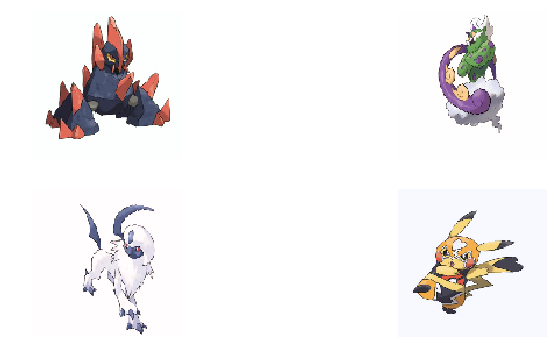

In [27]:
def get_batches(dirname, temp_dir=None, shuffle=True, batch_size=batch_size):
    gen = image.ImageDataGenerator(preprocessing_function=lambda x: (x - 127.5)/128,
                                  horizontal_flip=True,
                                  width_shift_range=0.09,
                                  height_shift_range=0.09,
                                  zoom_range=[1.1, 1.65],
                                  shear_range=0.18,
                                  fill_mode='constant',
                                  cval=255,
                                  channel_shift_range=7)
    return gen.flow_from_directory(dirname,
                                  target_size=(128,128),
                                  class_mode='binary',
                                  color_mode='rgb',
                                  shuffle=shuffle,
                                  save_to_dir=temp_dir,
                                  batch_size=batch_size)

batches = get_batches(train_path, temp_dir=temp_path)
#batches = get_batches(train_path)

for i in range(4000):
    batch, labels = next(batches)
print('max: {} min: {} mean: {}'.format(np.max(batch), np.min(batch), np.mean(batch)))
plots([image.load_img(os.path.join(temp_path, img)) for img in random.sample(os.listdir(temp_path), 4)])

In [20]:
from PIL import Image

def tile_images(image_stack):
    assert len(image_stack.shape) == 4
    image_list = [image_stack[i, :, :, :] for i in range(image_stack.shape[0])]
    #image_list = [image_stack[i, :, :] for i in range(image_stack.shape[0])]
    tiled_images = np.concatenate(image_list, axis=1)
    tiled_images = np.swapaxes(tiled_images, 0, 2)
    return tiled_images

def generate_images(generator, output_dir, epoch):
    test_image_stack = generator.predict(np.random.normal(size=(8, 128), scale=1)) 
    test_image_stack = (test_image_stack * 127.5) + 127.5
    test_image_stack = np.squeeze(np.round(test_image_stack).astype(np.uint8))
    tiled_output = tile_images(test_image_stack)
    tiled_output = Image.fromarray(tiled_output, mode='RGB')
    outfile = os.path.join(output_dir, 'epoch_{}.png'.format(epoch))
    tiled_output.save(outfile)

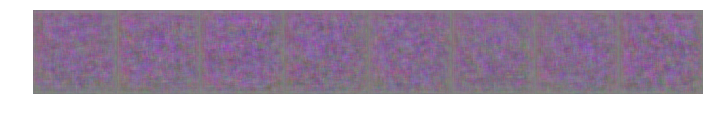

In [21]:
#import dcgan
#generator = dcgan.generator_model()
#generator.compile(optimizer=Adam(0.0001), loss='binary_crossentropy')

test_image_stack = generator.predict(np.random.normal(size=(8, 128), scale=1))
test_image_stack = (test_image_stack * 127.5) + 127.5
test_image_stack = np.squeeze(np.round(test_image_stack).astype(np.uint8))
tiled_output = tile_images(test_image_stack)
tiled_output = Image.fromarray(tiled_output, mode='RGB')
outfile = os.path.join(temp_path, 'perturb_test.png')
tiled_output.save(outfile)

plots([image.load_img(outfile)])

- Concensus from [Animeface-GAN](https://github.com/forcecore/Keras-GAN-Animeface-Character) and others seems to be generator loss of 2-4 and discriminator loss around 0.3 is good
- One sided label noising and both sided label smoothing for discriminator, no smoothing or noising for generator seems to work well for me

In [22]:
batches_per_epoch = int(1426 / batch_size)

true_positive_y = np.ones((batch_size, 1))
true_negative_y = np.zeros((batch_size, 1))
dummy_y = np.zeros((batch_size, 1)) + 0.5

epoch = 0
if epoch > 0:
    generator_model.load_weights(os.path.join(result_path, 'gan_g_weights{}.h5'.format(epoch)))
    discriminator_model.load_weights(os.path.join(result_path, 'gan_d_weights{}.h5'.format(epoch)))
    discriminator_loss = np.loadtxt(os.path.join(result_path, 'gan_d_loss_history.csv'))
    discriminator_loss = list(np.broadcast_to(
        np.expand_dims(discriminator_loss, axis=1),(discriminator_loss.shape[0], 4)))
    generator_loss =  list(np.loadtxt(os.path.join(result_path, 'gan_g_loss_history.csv')))
    batch_num = len(discriminator_loss) + 1
else:
    discriminator_loss = []
    generator_loss = []
    batch_num = 0

epoch += 1
print('Epoch ' + str(epoch) + '\n')
for batch, labels in batches: # folder labels not actually used
    
    if batch_num % batches_per_epoch == 0 and batch_num > 0:
        generate_images(generator, result_path, epoch)
        if generator_loss[-1] > 0.5:
            try:
                generator_model.save_weights(os.path.join(result_path, 'gan_g_weights{}.h5'.format(epoch)))
                discriminator_model.save_weights(os.path.join(result_path, 'gan_d_weights{}.h5'.format(epoch)))
            except:
                print('Weights could not be saved')
        epoch += 1
        print('\nEpoch ' + str(epoch))
    
    if len(batch) == batch_size:
        # smooth positive labels only
        positive_y = np.random.uniform(0.7, 1.2, size=(batch_size, 1))
        negative_y = np.zeros((batch_size, 1))+0.05
    
        # train discriminator with real, generated, and perturbed images
        noise = np.random.normal(size=(batch_size, 128), scale=1)
        discriminator_loss.append(
            discriminator_model.train_on_batch([batch, noise],[positive_y, negative_y, dummy_y]))
        
        print('D. Loss | Total: ' + str(discriminator_loss[-1][0])
              + ' | Real: ' + str(discriminator_loss[-1][1])
              + ' | Fake: ' + str(discriminator_loss[-1][2])
              + ' | Penalty: ' + str(discriminator_loss[-1][3]))
        np.savetxt(os.path.join(result_path, 'gan_d_loss_history.csv'), np.asarray(discriminator_loss)[:,0])

        # train generator to maximize discriminator loss
        noise2 = np.random.normal(size=(batch_size, 128), scale=1)
        positive_y = np.random.uniform(0.85, 1.05, size=(batch_size, 1))
        generator_loss.append(
            generator_model.train_on_batch(noise2, positive_y))
            
        print('G. Loss: '+  str(generator_loss[-1]))
        np.savetxt(os.path.join(result_path, 'gan_g_loss_history.csv'), np.asarray(generator_loss))
    batch_num += 1

Epoch 1

D. Loss | Total: 0.7543246746063232 | Real: 0.7383917570114136 | Fake: 0.6781107187271118 | Penalty: 0.9386183023452759
G. Loss: 0.6092567443847656
D. Loss | Total: 0.678094744682312 | Real: 0.3791670799255371 | Fake: 0.8430660367012024 | Penalty: 0.9460073709487915
G. Loss: 1.2392964363098145
D. Loss | Total: 0.5844422578811646 | Real: 0.5116893649101257 | Fake: 0.487617164850235 | Penalty: 0.9235982298851013
G. Loss: 1.5726020336151123
D. Loss | Total: 0.5573656558990479 | Real: 0.31633585691452026 | Fake: 0.6100943088531494 | Penalty: 0.9339677691459656
G. Loss: 2.1033992767333984
D. Loss | Total: 0.6138777732849121 | Real: 0.6760687828063965 | Fake: 0.44122251868247986 | Penalty: 0.8348063230514526
G. Loss: 0.19561892747879028
D. Loss | Total: 1.6251261234283447 | Real: 0.20611050724983215 | Fake: 3.360788345336914 | Penalty: 0.9918328523635864
G. Loss: 1.1153076887130737
D. Loss | Total: 0.683881402015686 | Real: 0.648253321647644 | Fake: 0.6510626077651978 | Penalty: 0.8

D. Loss | Total: 0.36814188957214355 | Real: 0.25745001435279846 | Fake: 0.20771202445030212 | Penalty: 0.9103853106498718
G. Loss: 2.4552719593048096
D. Loss | Total: 0.3494874835014343 | Real: 0.20757196843624115 | Fake: 0.2076481133699417 | Penalty: 0.9169971942901611
G. Loss: 3.0030977725982666
D. Loss | Total: 0.3867455720901489 | Real: 0.30426669120788574 | Fake: 0.20350849628448486 | Penalty: 0.918177604675293
G. Loss: 3.124253749847412
D. Loss | Total: 0.3512113690376282 | Real: 0.20819859206676483 | Fake: 0.20599432289600372 | Penalty: 0.9276710748672485
G. Loss: 3.189910650253296
D. Loss | Total: 0.3726179003715515 | Real: 0.2630220055580139 | Fake: 0.2073582410812378 | Penalty: 0.9223289489746094
G. Loss: 3.047427177429199
D. Loss | Total: 0.31353724002838135 | Real: 0.12447060644626617 | Fake: 0.2041253298521042 | Penalty: 0.9104942679405212
G. Loss: 2.8185744285583496
D. Loss | Total: 0.33159786462783813 | Real: 0.16465452313423157 | Fake: 0.2059139609336853 | Penalty: 0.9

G. Loss: 2.5458502769470215
D. Loss | Total: 0.3249901533126831 | Real: 0.12832117080688477 | Fake: 0.20353884994983673 | Penalty: 0.9612305760383606
G. Loss: 2.9036378860473633
D. Loss | Total: 0.30480891466140747 | Real: 0.07798386365175247 | Fake: 0.20045924186706543 | Penalty: 0.9671583771705627
G. Loss: 3.30208683013916
D. Loss | Total: 0.3717193901538849 | Real: 0.24487122893333435 | Fake: 0.20180831849575043 | Penalty: 0.9652377963066101
G. Loss: 3.3721814155578613
D. Loss | Total: 0.3956931233406067 | Real: 0.3039769232273102 | Fake: 0.20598477125167847 | Penalty: 0.9585422277450562
G. Loss: 3.3767170906066895
D. Loss | Total: 0.3679616451263428 | Real: 0.2423754334449768 | Fake: 0.20253953337669373 | Penalty: 0.9499782919883728
G. Loss: 3.1177029609680176
D. Loss | Total: 0.3499637544155121 | Real: 0.16553902626037598 | Fake: 0.22902724146842957 | Penalty: 0.960686206817627
G. Loss: 2.4763002395629883
D. Loss | Total: 0.3255212903022766 | Real: 0.12700335681438446 | Fake: 0.21

D. Loss | Total: 0.3851028084754944 | Real: 0.30019453167915344 | Fake: 0.20113897323608398 | Penalty: 0.9228469133377075
G. Loss: 2.9770517349243164
D. Loss | Total: 0.35082465410232544 | Real: 0.19811078906059265 | Fake: 0.20103998482227325 | Penalty: 0.9558217525482178
G. Loss: 2.9448904991149902
D. Loss | Total: 0.3705308735370636 | Real: 0.24553754925727844 | Fake: 0.2007662057876587 | Penalty: 0.9600468873977661
G. Loss: 2.966848611831665
D. Loss | Total: 0.414248526096344 | Real: 0.36312705278396606 | Fake: 0.20113521814346313 | Penalty: 0.9427181482315063
G. Loss: 2.851999282836914
D. Loss | Total: 0.37136110663414 | Real: 0.26417088508605957 | Fake: 0.20135921239852905 | Penalty: 0.9257452487945557
G. Loss: 2.6577811241149902

Epoch 5
D. Loss | Total: 0.31887778639793396 | Real: 0.12065435945987701 | Fake: 0.20504146814346313 | Penalty: 0.9429972171783447
G. Loss: 2.5777015686035156
D. Loss | Total: 0.39240801334381104 | Real: 0.3083476722240448 | Fake: 0.20277543365955353 | P

D. Loss | Total: 0.35693222284317017 | Real: 0.228255957365036 | Fake: 0.20215818285942078 | Penalty: 0.923832893371582
G. Loss: 2.9112067222595215
D. Loss | Total: 0.3533428907394409 | Real: 0.22110691666603088 | Fake: 0.20228339731693268 | Penalty: 0.9199339151382446
G. Loss: 3.1253457069396973
D. Loss | Total: 0.35541635751724243 | Real: 0.21445633471012115 | Fake: 0.20185743272304535 | Penalty: 0.9444541931152344
G. Loss: 3.247401237487793
D. Loss | Total: 0.41366636753082275 | Real: 0.36192765831947327 | Fake: 0.20337717235088348 | Penalty: 0.9377222061157227
G. Loss: 3.12788987159729
D. Loss | Total: 0.35466229915618896 | Real: 0.21927033364772797 | Fake: 0.20231588184833527 | Penalty: 0.9301389455795288
G. Loss: 3.046504259109497
D. Loss | Total: 0.3833499848842621 | Real: 0.2902261018753052 | Fake: 0.20148086547851562 | Penalty: 0.9333359599113464
G. Loss: 3.033454418182373
D. Loss | Total: 0.3265652060508728 | Real: 0.15766072273254395 | Fake: 0.20121029019355774 | Penalty: 0.

D. Loss | Total: 0.35640978813171387 | Real: 0.2302742451429367 | Fake: 0.2007620632648468 | Penalty: 0.9199762344360352
G. Loss: 2.8177123069763184
D. Loss | Total: 0.2944599390029907 | Real: 0.07505078613758087 | Fake: 0.20202569663524628 | Penalty: 0.9181467294692993
G. Loss: 2.845696449279785
D. Loss | Total: 0.32606130838394165 | Real: 0.15286441147327423 | Fake: 0.20068471133708954 | Penalty: 0.9232083559036255
G. Loss: 2.8393280506134033
D. Loss | Total: 0.3164319694042206 | Real: 0.1327986866235733 | Fake: 0.20241619646549225 | Penalty: 0.9117300510406494
G. Loss: 2.7549819946289062
D. Loss | Total: 0.31555914878845215 | Real: 0.12535379827022552 | Fake: 0.20047083497047424 | Penalty: 0.926146388053894
G. Loss: 2.847991943359375
D. Loss | Total: 0.40098947286605835 | Real: 0.3396967053413391 | Fake: 0.20116817951202393 | Penalty: 0.9232174158096313
G. Loss: 2.8212084770202637
D. Loss | Total: 0.3126339614391327 | Real: 0.12505102157592773 | Fake: 0.19994118809700012 | Penalty: 

D. Loss | Total: 0.32652610540390015 | Real: 0.36284127831459045 | Fake: 0.20379184186458588 | Penalty: 0.49936431646347046
G. Loss: 3.157728672027588
D. Loss | Total: 0.3532261848449707 | Real: 0.4583319127559662 | Fake: 0.20582887530326843 | Penalty: 0.4378093481063843
G. Loss: 3.1002116203308105
D. Loss | Total: 0.3330897390842438 | Real: 0.40304240584373474 | Fake: 0.20455807447433472 | Penalty: 0.45024776458740234
G. Loss: 3.171111583709717
D. Loss | Total: 0.295676052570343 | Real: 0.2928221821784973 | Fake: 0.20380154252052307 | Penalty: 0.4851328134536743
G. Loss: 3.0003578662872314
D. Loss | Total: 0.34211617708206177 | Real: 0.3262375593185425 | Fake: 0.2049507349729538 | Penalty: 0.6482043862342834
G. Loss: 2.821072578430176
D. Loss | Total: 0.24777565896511078 | Real: 0.15414650738239288 | Fake: 0.20335446298122406 | Penalty: 0.5238763093948364
G. Loss: 2.67744517326355
D. Loss | Total: 0.3094543218612671 | Real: 0.30832281708717346 | Fake: 0.20318999886512756 | Penalty: 0.

D. Loss | Total: 0.31241846084594727 | Real: 0.21587258577346802 | Fake: 0.2132216989994049 | Penalty: 0.7039036750793457
G. Loss: 3.1894330978393555
D. Loss | Total: 0.3344194293022156 | Real: 0.30596768856048584 | Fake: 0.2019008845090866 | Penalty: 0.6563600897789001
G. Loss: 3.3892548084259033
D. Loss | Total: 0.3208532929420471 | Real: 0.2629968523979187 | Fake: 0.20661553740501404 | Penalty: 0.6650417447090149
G. Loss: 3.8674890995025635
D. Loss | Total: 0.31615352630615234 | Real: 0.2637462913990021 | Fake: 0.21388891339302063 | Penalty: 0.6254972219467163
G. Loss: 3.451490640640259
D. Loss | Total: 0.2891947329044342 | Real: 0.21518072485923767 | Fake: 0.2122725546360016 | Penalty: 0.5910670757293701
G. Loss: 3.3132123947143555
D. Loss | Total: 0.2783523201942444 | Real: 0.1708192676305771 | Fake: 0.20651963353157043 | Penalty: 0.6370837688446045
G. Loss: 2.608973741531372
D. Loss | Total: 0.31113213300704956 | Real: 0.22327324748039246 | Fake: 0.2077430784702301 | Penalty: 0.6

KeyboardInterrupt: 

## Compare with hypergan card images because keras is soooo slow

- Seriously, raw tensorflow is like at least 10 times faster than keras for this. Also keras keeps making me tweak the hyperparameters every few epochs to avoid nans. I really should learn pytorch soon. Maybe my generator and discriminator architectures are overkill, but the double evaluation for each model and the gradient penalty are very inefficient in keras.

- Looks like hypergan isn't very effective for this task either - discriminator or generator loss goes to 0 after just a few epochs, no matter what hyperparameters I try. May need more data augmentation, and it's easier to do that in keras.

## Create Card Mockups

- Using Paulsnoop's BWXY card templates and symbol sheet (from deviantart)

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import os, textwrap

data_dir = '/home/ubuntu/fastai-data/pokemon_img'
template_path = os.path.join(data_dir, 'templates')

In [ ]:
import yaml, pprint

card_data = []
with open('cards_generated_tf.yml') as f:
     card_data = yaml.load(f)

In [ ]:
# only supports basic pokemon for now
def get_energy_img(energy, category):
    energies = ['Grass', 'Fire', 'Water', 'Electric', 'Psychic', 'Fighting',
                'Dark', 'Metal', 'Fairy', 'Dragon', 'Colorless']
    full_img = Image.open('symbols.png')
    if category is 'attack':
        img = full_img.crop((46+energies.index(energy)*57, 85, 85+energies.index(energy)*57, 135))
    if category is 'weakness':
        img = full_img.crop((50+energies.index(energy)*57, 210, 80+energies.index(energy)*57, 250))
    return img

def gen_card_img(card):
    if card['supertype'] == 'Pokémon':
        img = Image.open(os.path.join(template_path,
                         card['supertype'], 'Basic',
                         card['types'][0]+'.png'))
        
        d = ImageDraw.Draw(img)
        
        f = ImageFont.truetype(font='fonts/gill-rb.ttf', size=48)
        d.text((180,36), card['name'], font=f, fill='black')

        f = ImageFont.truetype(font='fonts/gill-rb.ttf', size=18)
        d.text((556, 68), 'HP', font=f, fill='black')

        f = ImageFont.truetype(font='fonts/futura-cb.ttf', size=44)
        d.text((582, 42), str(card['hp']), font=f, fill='black')
        
        f = ImageFont.truetype(font='fonts/futura-cb.ttf', size=30)
        if card['weaknesses']:
            energy_img = get_energy_img(card['weaknesses']['type'], 'weakness')
            img.paste(energy_img, (65, 888), energy_img)
            d.text((100, 890), card['weaknesses']['value'], font=f, fill='black')
        if card['resistances']:
            energy_img = get_energy_img(card['resistances']['type'], 'weakness')
            img.paste(energy_img, (195, 888), energy_img)
            d.text((230, 890), card['resistances']['value'], font=f, fill='black')
        
        full_img = Image.open('symbols.png')
        retreat_img = full_img.crop((517, 433, 517+32*len(card['retreat_cost']),463))
        img.paste(retreat_img, (150, 938), retreat_img)

        start_height = 560
        if 'ability' in card:
            ability = card['ability']
            
            ability_img = full_img.crop((50, 433, 212, 475))
            img.paste(ability_img, (60, start_height+5), ability_img)
            
            f = ImageFont.truetype(font='fonts/gill-cb.ttf', size=44)
            d.text((240, start_height), ability['name'], font=f, fill='#c23600')
            
            f = ImageFont.truetype(font='fonts/gill-rp.ttf', size=30)
            d.multiline_text((60, start_height+54), textwrap.fill(ability['text'], width=48), font=f, fill='black')
            
            start_height += 80 + d.multiline_textsize(textwrap.fill(ability['text'], width=48), font=f)[1]
        if 'attacks' in card:
            for attack in card['attacks']:
                if start_height >= 760:
                    break
                
                for n in range(len(attack['cost'])):
                    energy_img = get_energy_img(attack['cost'][n],'attack')
                    img.paste(energy_img, (60+n*45, start_height), energy_img)
                
                f = ImageFont.truetype(font='fonts/gill-cb.ttf', size=44)
                d.text((115+n*45, start_height), attack['name'], font=f, fill='black')

                f = ImageFont.truetype(font='fonts/futura-cb.ttf', size=44)
                d.text((612, start_height), attack['damage'], font=f, fill='black')

                f = ImageFont.truetype(font='fonts/gill-rp.ttf', size=30)
                d.multiline_text((60, start_height+54), textwrap.fill(attack['text'], width=48), font=f, fill='black')

                start_height += 80 + d.multiline_textsize(textwrap.fill(attack['text'], width=48), font=f)[1]
        
    elif card['supertype'] == 'Trainer':
        img = Image.open(os.path.join(template_path,
            card['supertype'], (card['subtype'].replace(' ','_') if card['subtype'] else 'Supporter')+'.png'))
        d = ImageDraw.Draw(img)
        
        f = ImageFont.truetype(font='fonts/gill-rb.ttf', size=44)
        d.text((85,105), card['name'], font=f, fill='black')
        
        f = ImageFont.truetype(font='fonts/gill-rp.ttf', size=30)
        d.multiline_text((95, 570), textwrap.fill(card['text'] if card['text'] else '', width=42), font=f, fill='black')
    else:
        img = Image.open(os.path.join(template_path,
            card['supertype'], (card['subtype'].replace(' ','_') if card['subtype'] else 'Supporter')+'.png'))
        d = ImageDraw.Draw(img)
        
        f = ImageFont.truetype(font='fonts/gill-rb.ttf', size=30)
        d.text((80,100), 'Special Energy', font=f, fill='black')
        
        f = ImageFont.truetype(font='fonts/gill-rb.ttf', size=40)
        d.text((60,655), card['name'], font=f, fill='black')
        
        f = ImageFont.truetype(font='fonts/gill-rp.ttf', size=30)
        d.multiline_text((60, 720), textwrap.fill(card['text'], width=48), font=f, fill='black')
    
    background = Image.open('holosheet.jpg')
    background.paste(img, (0, 0), img)
    img = background

    img.thumbnail((512,512))
    return img

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

card_names = ['Auror', 'Mr. Show the top card.', 'Scorched Seal', 'Bubble']

card = None
for name in card_names:
    card = next((c for c in card_data if c['name'] == name), None)
    if card:
        #pprint.pprint(card)
        gen_card_img(card)